In [ ]:
%%bash

wget -qO "../../datasets/blood_transfusion.csv" "https://github.com/INRIA/scikit-learn-mooc/raw/master/datasets/blood_transfusion.csv"

In [1]:
import pandas as pd

blood_transfusion = pd.read_csv("../../datasets/blood_transfusion.csv")
target_name = "Class"
data = blood_transfusion.drop(columns=target_name)
target = blood_transfusion[target_name]

We can have a look to the target variable:

In [2]:
target.head()

0        donated
1        donated
2        donated
3        donated
4    not donated
Name: Class, dtype: object

Since the target has categorical values, it is a classification problem. We can check how many classes are present to know if we have a binary or a multiclass classification problem.

In [3]:
target.unique()

array(['donated', 'not donated'], dtype=object)

We see that the problem is a binary classification with 2 classes, namely `donated` and `not donated`. Now, we should check the number of samples in each of the class to know the ratio of the class counts.

In [4]:
target.value_counts(normalize=True)

not donated    0.762032
donated        0.237968
Name: Class, dtype: float64

~75% of the samples belong to the class `not donated` while only ~25% of the samples belong to the class `donated`.

The code below allows to compute the average of the accuracy scores obtained by performing a 10-fold cross-validation.

In [9]:
%%time
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

dummy = DummyClassifier(strategy='most_frequent')
scores = cross_val_score(dummy, data, target, cv=10)
print("The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation accuracy is: 0.762 +/- 0.004
CPU times: user 19.9 ms, sys: 74 µs, total: 20 ms
Wall time: 19.4 ms


This is not a surprise to get a score a high as ~75%. This is due to the class imbalanced nature of the dataset: always predicting `not donated` class will be correrct ~75% of the time since this the natural proportion of samples belonging to this class in the data.

The code to compute the balanced accuracy instead of the accuracy is the following:

In [10]:
%%time
dummy = DummyClassifier(strategy='most_frequent')
scores = cross_val_score(dummy, data, target, cv=10, 
    scoring='balanced_accuracy')
print("The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation accuracy is: 0.500 +/- 0.000
CPU times: user 16.6 ms, sys: 7.79 ms, total: 24.4 ms
Wall time: 22.1 ms


In this case, the score is corrected such that such a dummy approach will give a score of 50%. You can learn more about how balanced_accuracy is computed in the [`scikit-learn documentation`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html). `balanced_accuracy` therefore makes it easier to distingush good from bad classifier on imbalanced classification problems.

Why is it relevant to add a preprocessing step to scale the data using a `StandardScaler` when working with a `KNeighborsClassifier`?

`k-nearest neighbors` is based on computing some distances. Features need to be normalized to contribute approximately equally to the distance computation.

Computing distances on scaled or un-scaled data takes similar time but the resulting distance values could be very different and therefore ordering of which sample is closet neighbor to which sample also. For instance: if you have two variables A and B where A has values which vary between 0 and 1000000 (e.g. the price of a house in euros) and B is a variable that varies between 0 and 30 (e.g. the average outside air temperature in Celsius degrees), then computing distances between rows of such a database will be mostly impacted by the difference in values of the A column and the values of B column will be comparatively ignored. If one applies `StandardScaler` to such a database, both the values of A and B will be approximately between -3 and 3 and the neighbor structure will be impacted by both variables.

The code below allow to list all parameters that can be set in our scikit-learn pipeline.

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

model = make_pipeline(StandardScaler(), KNeighborsClassifier())
model.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

In this case, the number of neighbors K is 5. This means that when the model has to predict the class of a given test sample, it will compute the distances between that test sample and all the samples of the training set, order them by ascending distances and return the class of the majority of the 5 closest neighbors.

Compute the average test score and the average train score and compare them. Make sure to pass `return_train_score=True` to the `cross_validate` function to also compute the train score.

In [11]:
%%time
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, data, target, cv=10, 
    return_train_score=True)
cv_results = pd.DataFrame(cv_results)
print(cv_results)
cv_results[['train_score', 'test_score']].mean()

   fit_time  score_time  test_score  train_score
0  0.005026    0.006075    0.373333     0.842496
1  0.003603    0.003755    0.400000     0.815750
2  0.003601    0.003574    0.560000     0.805349
3  0.003515    0.003670    0.706667     0.827637
4  0.003519    0.003572    0.733333     0.820208
5  0.003409    0.003616    0.760000     0.827637
6  0.003413    0.003620    0.680000     0.821694
7  0.003374    0.003595    0.786667     0.812779
8  0.003448    0.003633    0.743243     0.821958
9  0.003340    0.003589    0.783784     0.817507
CPU times: user 284 ms, sys: 489 µs, total: 284 ms
Wall time: 282 ms


train_score    0.821302
test_score     0.652703
dtype: float64

We see that the gap between train and test scores is large. In addition, the average score of on the training sets is good while the average score on the testing sets is really bad. They are the signs of a overfitting model.

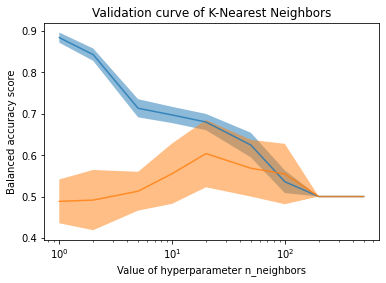

CPU times: user 348 ms, sys: 11.3 ms, total: 360 ms
Wall time: 1.21 s


In [15]:
%%time
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

param_range = [1, 2, 5, 10, 20, 50, 100, 200, 500]
param_name = "kneighborsclassifier__n_neighbors"
train_scores, test_scores = validation_curve(model, data, target, 
    param_name=param_name, param_range=param_range,
    cv=5, scoring='balanced_accuracy', n_jobs=2)

_, ax = plt.subplots()
for name, scores in zip(
    ["Training score", "Testing score"], [train_scores, test_scores]):
    ax.plot(param_range, scores.mean(axis=1), linestyle="-", 
        label=name, alpha=0.8)
    ax.fill_between(param_range, scores.mean(axis=1) - scores.std(axis=1),
        scores.mean(axis=1) + scores.std(axis=1), alpha=0.5, 
        label=f"std.dev.{name.lower()}")
    
ax.set_xticks(param_range)
ax.set_xscale("log")
ax.set_xlabel("Value of hyperparameter n_neighbors")
ax.set_ylabel("Balanced accuracy score")
ax.set_title("Validation curve of K-Nearest Neighbors")
plt.show()

Underfitting happens when the gap between train and test scores is low and that both scores are low. When `n_neighbors` is high, underfitting occurs. The model lacks expressivity because it always considers the majority class of a large number of data points. Its prediction tends to be always the same, irrespective of the test point of interest.

Overfitting happens when the gap between train and test scores is high and that the test score is low. When `n_neighbors` is low, the model looks at small number of data points around the test points of interest. In this case the model is too flexible: it is sensible to noise rather than the underlying structure of the data.

Generalization happens when the gap between train and test scores is relatively low and that the test scores is maximum. In our case, the range between 20 to 50 neighbors seems the best. Indeed, for 20 neighbors, the gap between train and test scores is larger than with 50 neighbors; however the test score is better with 20 neighbors.

Considering an intermediate value for `n_neighbors` makes it possible to limit overfitting by averaging out the influence of a few noisy samples. On the other hand, the model can also avoid underfitting by focusing its decision on the details of a region of interest close to the test sample. The optimum value for `n_neighbors` is typically very dataset dependent and can be influenced by the choice of the distance metric, the scaling of the features, the presence of noisy sample, the balance between classes.

Finally note while k-nearest neighbors is useful baseline, it can be to slow to predict on large datasets with many samples and features and practitioners would instead favor other models such as gradient boosted trees for instance. On the particular dataset used for this quiz, the best accuracy achieved by the nearest neighbors model does not seem to be high enough to make it useful.